In [32]:
#import relevant libraries and packages

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report 


STEP 1: ANALYZING DATA

In [3]:
cols = pd.read_csv('/Users/pree/Desktop/SPAM_classifier/spam.csv',encoding="ISO-8859-1", nrows=1).columns
df = pd.read_csv('/Users/pree/Desktop/SPAM_classifier/spam.csv', usecols=cols,encoding="ISO-8859-1" )
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
#drop unwanted columns
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)


#rename columns
df = df.rename(columns={'v1': 'label', 'v2': 'sms'})
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Text(0, 0.5, 'Counts')

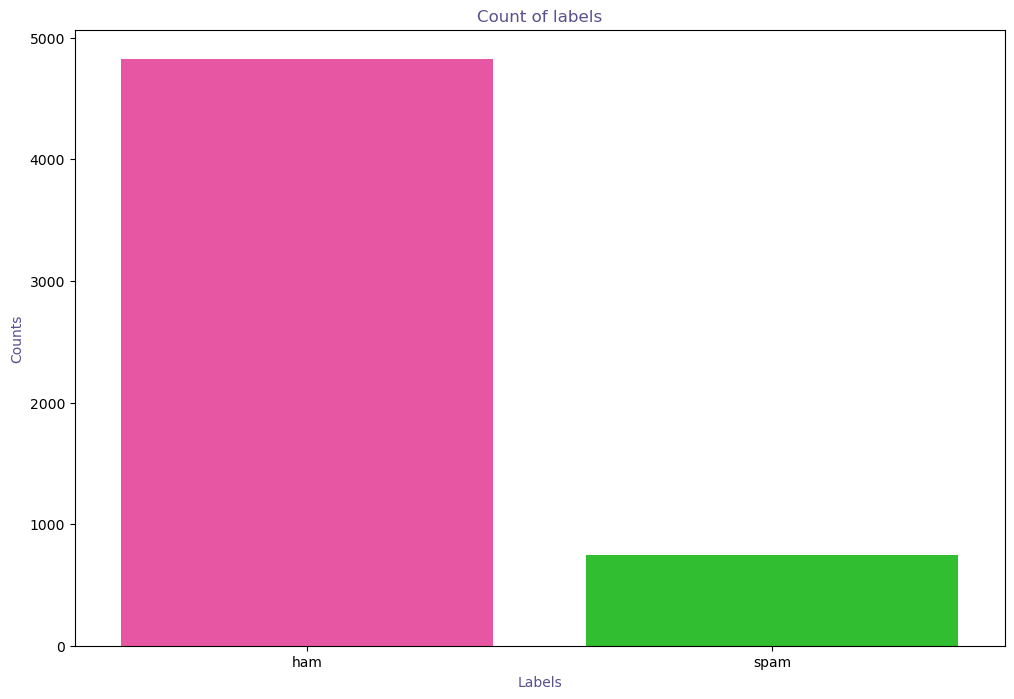

In [7]:
#Palette
cols = ["#FF3EA5FF", "#19D719"]

#Let's take  a look at the count of our labels and check if there is imbalance between
plt.figure(figsize=(12,8))
fg = sns.countplot(x= df["label"], palette= cols)
fg.set_title("Count of labels", color="#58508d")
fg.set_xlabel("Labels", color="#58508d")
fg.set_ylabel("Counts", color="#58508d")

Observation: The countplot clearly shows imbalance of data

Data exploration: We will first use NLP to assess the sms text and create some new columns like number of characters, number of words and number of sentences.

In [8]:
#Adding new columns
df['num_characters'] = df['sms'].str.len()
df['num_words'] = df.apply(lambda row: nltk.word_tokenize(row['sms']), axis=1).apply(len)
df['num_sentences'] = df.apply(lambda row: nltk.sent_tokenize(row['sms']), axis=1).apply(len)

#Leet's take a look at the statistical analysis
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
num_words,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
num_sentences,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


<Figure size 1200x800 with 0 Axes>

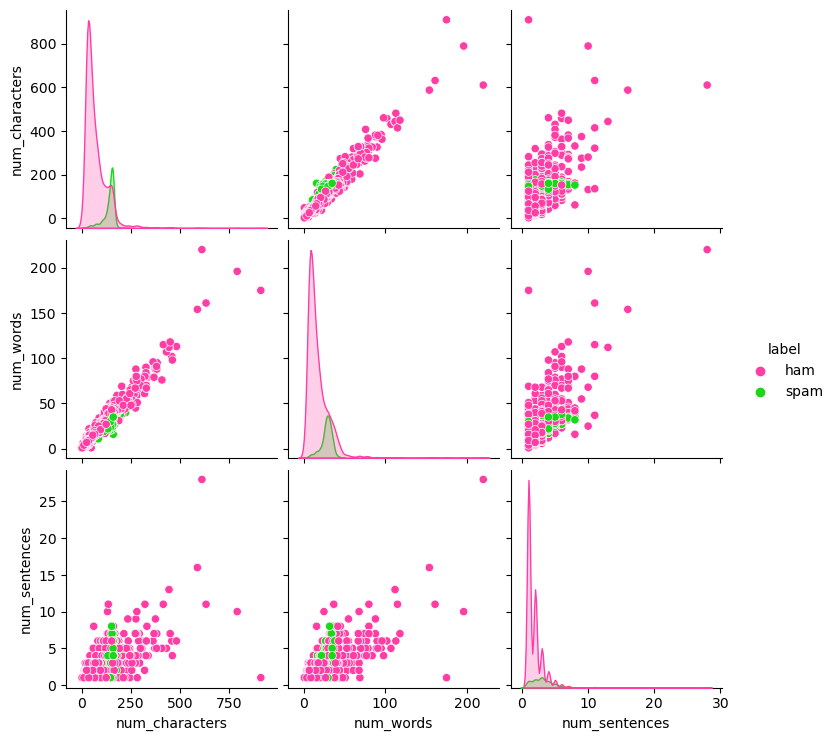

In [9]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="label",palette=cols)
plt.show(fg)

Observation: As is seen in the paiplots, we see a few outliers under the ham label. These essentially indicate the length of the sms'.This is interesting as we could put a cap over one of these (perhaps num_characters). We will go ahead and drop these outliers.

In [10]:
#Dropping outliers with a cap of 350
df = df[(df['num_characters'] < 350)]


In [11]:
#Cross-checking
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_characters,5548.0,78.368962,52.802290,2.0,35.0,61.0,121.0,338.0
num_words,5548.0,18.259373,11.814699,1.0,9.0,15.0,27.0,90.0
num_sentences,5548.0,1.940339,1.293384,1.0,1.0,1.0,2.0,11.0


<Figure size 1200x800 with 0 Axes>

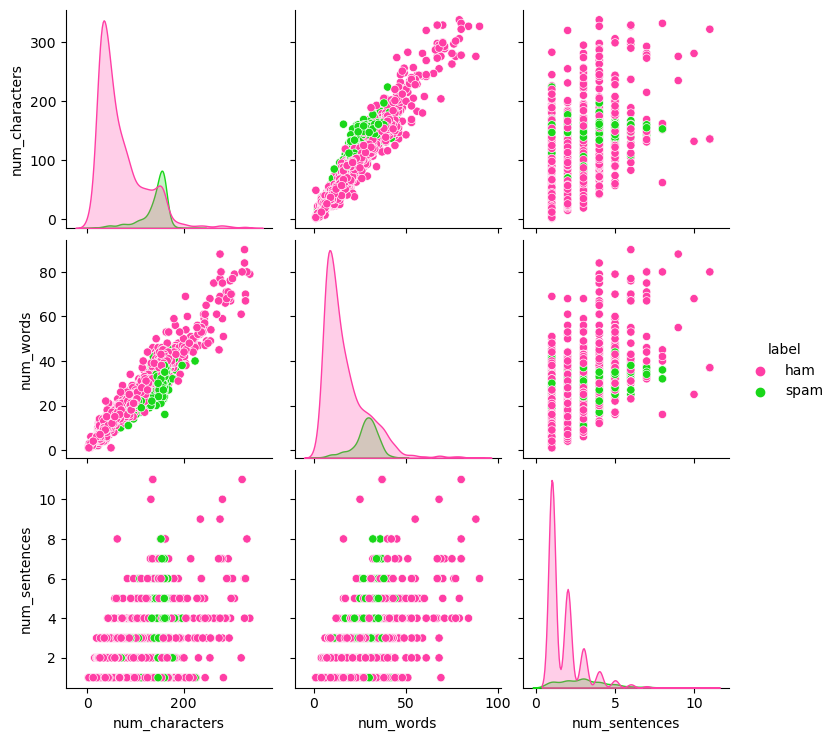

In [12]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="label",palette=cols)
plt.show(fg)

STEP 2: CLEANING DATA

As we are analyzing text we will be using Natural Language Processing(NLP) methodologies to do so.  We will clean the sms text in 2 steps:

    1. Remove all stopwords in English and also numbers and special characters and then  extract only alphabetical characters from the text

    2. We will then convert the sms text to lower case

We will then further preprocess the text

In [13]:
#Let's take a look at our text
df[['sms']].head()

,sms
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
#Lets have a look at a sample of texts before cleaning
print("The First 5 SMS Texts before cleaning:\033[0m",*df["sms"][:5], sep = "\n")

The First 5 SMS Texts before cleaning:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [15]:
# Defining a function to clean up the text
def Clean(text):
    sms = re.sub('[^a-zA-Z]', ' ', text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["clean_sms"] = df["sms"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("The First 5 Texts after cleaning:\033[0m",*df["clean_sms"][:5], sep = "\n")

The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


STEP 3: TOKENIZATION

Tokenization is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words. I am splitting the clean_sms into words at this step.

In [16]:
df['token_sms'] = df.apply(lambda row: nltk.word_tokenize(row["clean_sms"]), axis=1)
print("The First 5 Texts after tokenizing:\033[0m",*df["token_sms"][:5], sep = "\n")

The First 5 Texts after tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


STEP 5 : REMOVING STOPWORDS

In Natural Language Processing (NLP), "stopwords" refer to commonly used words in a language, such as "the", "a", "an", "is", "of", "and", etc. These words are often very frequent in text but usually do not carry much meaning and are not useful for certain NLP tasks such as text classification, sentiment analysis, or topic modeling.

Removing stopwords in NLTK (Natural Language Toolkit) is the process of filtering out such words from a text corpus. NLTK provides a built-in list of stopwords for several languages, including English, Spanish, German, French, and many others.

By removing stopwords, we can reduce the size of the text data and improve the performance of NLP models, as they can focus on more meaningful words and phrases that carry more information about the topic or sentiment of the text. NLTK provides a simple and efficient way to remove stopwords from text data using its stopwords module.

In [17]:
# Removing the stopwords function
def remove_stopwords(text):
    # Load the English stopwords
    stop_words = set(stopwords.words('english'))

    # Remove stopwords from the list of words
    filtered_words = [word for word in text if word not in stop_words]

    return filtered_words

In [18]:
df['nostopwords_sms'] = df['token_sms'].apply(remove_stopwords)

print("The First 5 Texts after removing the stopwords:\033[0m",*df["nostopwords_sms"][:5], sep = "\n")

The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


STEP 6 : LEMMETIZATION

Stemming is a text normalization technique that involves reducing words to their base or root form by removing their suffixes and prefixes. It's a simple and fast process that can be used to group similar words together.

Lemmatization is a more sophisticated text normalization technique that also involves reducing words to their base or root form, but with the added step of considering the context and part of speech of the word. This produces a more accurate base form of the word, but can be slower and more complex than stemming.

Both stemming and lemmatization are used to reduce the complexity of text data, making it easier to process and analyze. They are commonly used in natural language processing applications such as search engines, chatbots, and text analysis tools.

In [19]:

# create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# define a function to lemmatize 
def lemmatize_token(token):
    return lemmatizer.lemmatize(token)



In [20]:
df['lemmatized_sms'] = df['nostopwords_sms'].apply(lambda x: [lemmatize_token(token) for token in x])

print("The First 5 Texts after lemmetizing:\033[0m",*df["lemmatized_sms"][:5], sep = "\n")

The First 5 Texts after lemmetizing:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'life', 'around', 'though']


STEP 7 : VECTORIZE

Vectorization is a technique used to convert textual data into a numerical format for processing in Natural Language Processing (NLP). A commonly used method for vectorization is TF-IDF, which stands for Term Frequency - Inverse Document Frequency. This approach involves representing each word in the data as a matrix, a process also referred to as word embedding or word vectorization.

To vectorize preprocessed data, the following steps can be followed:

    Create a corpus of lemmatized text
    Convert the corpus into vector form
    Label encode the classes in the target

It's worth noting that columns in the data are often stacked for the purpose of explanation.

In [21]:
# create a corpus from the 'lemmatized_sms' column
corpus = []

for i in df['lemmatized_sms']:
    sms = ' '.join([row for row in i])
    corpus.append(sms)
    
corpus[:5]
print("The First 5 lines of the corpus:\033[0m",*corpus[:5], sep = "\n")

The First 5 lines of the corpus:
go jurong point crazy available bugis n great world la e buffet cine got amore wat
ok lar joking wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf life around though


In [22]:
#Changing text data in to numbers

# create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# fit the vectorizer to the corpus and transform the corpus into a matrix called X(as we will have the corpus as the X coloumn and y as the target(label) column
X = vectorizer.fit_transform(corpus).toarray()

In [23]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

STEP 8 : MODEL BUILDING

MODEL BUILDING

Steps involved in the Model Building

    Setting up features and target as X and y
    Splitting the testing and training sets
    Build a pipeline of model for four different classifiers.
    
        Naïve Bayes
        RandomForestClassifier
        KNeighborsClassifier
        Support Vector Machines
    
    Fit all the models on training data
    Get the cross-validation on the training set for all the models for accuracy

In [24]:
# split the data into training and testing sets
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# create a list of classifiers
classifiers = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), GaussianNB()]

# iterate through the list of classifiers
for clf in classifiers:
    # perform 10-fold cross-validation
    scores = cross_val_score(clf, X, y, cv=10)
    # print the mean and standard deviation of the cross-validation scores
    print(type(clf).__name__, scores.mean(), "+/-", scores.std())

LogisticRegression 0.9632305590789345 +/- 0.004350205121977794
DecisionTreeClassifier 0.9662952483169089 +/- 0.0059215571360637966
RandomForestClassifier 0.9785501024490193 +/- 0.0062173695422507325
SVC 0.9769291312973623 +/- 0.005569248509990719
GaussianNB 0.8759953816632517 +/- 0.013053627298206406


STEP 9 : EVALUATING MODELS

9 a. Confusion matrix

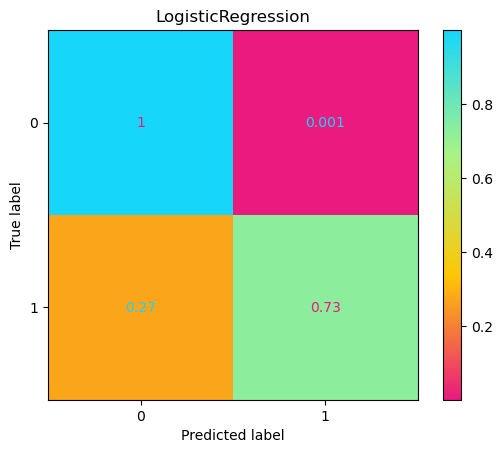

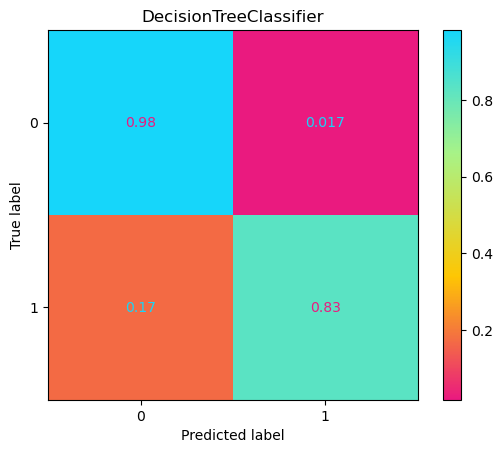

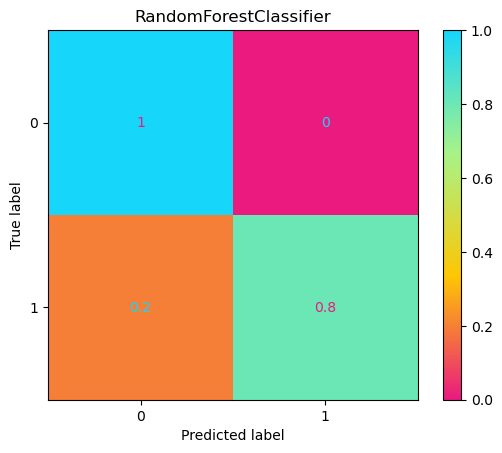

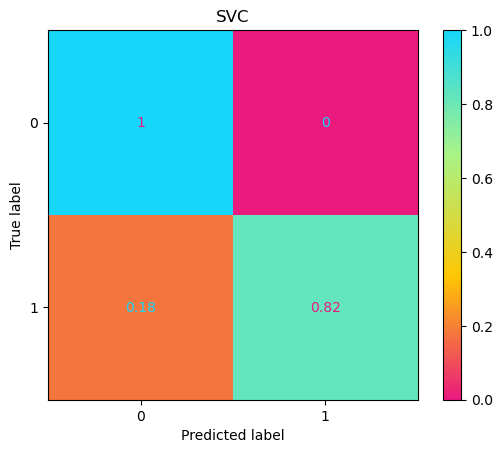

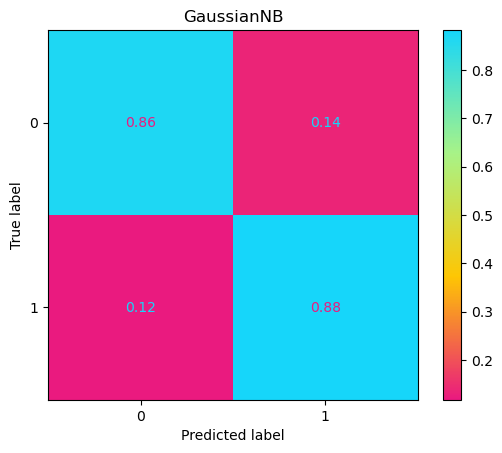

In [53]:
#color palette
colors= ['#EA1A7F','#FEC603','#A8F387','#16D6FA']

# Create custom colormap using hex codes
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# create a list of classifiers
classifiers = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), GaussianNB()]

# iterate through the list of classifiers
for clf in classifiers:
    # fit the classifier to the training data
    clf.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = clf.predict(X_test)

    # compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')

  
    
    # plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=cmap)
    plt.title(type(clf).__name__)
    plt.show()


9 b. Classification/ Accuracy report

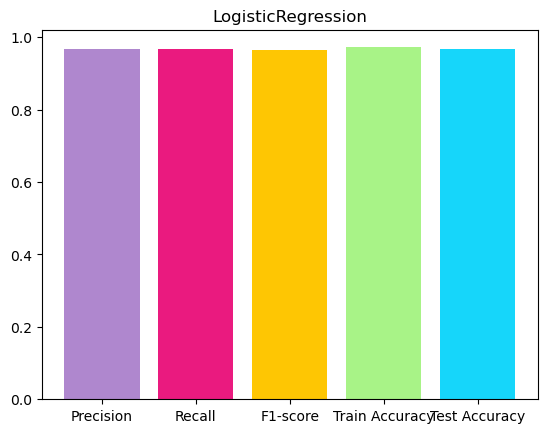

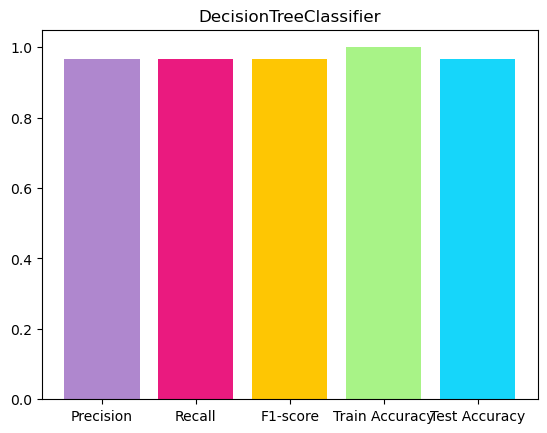

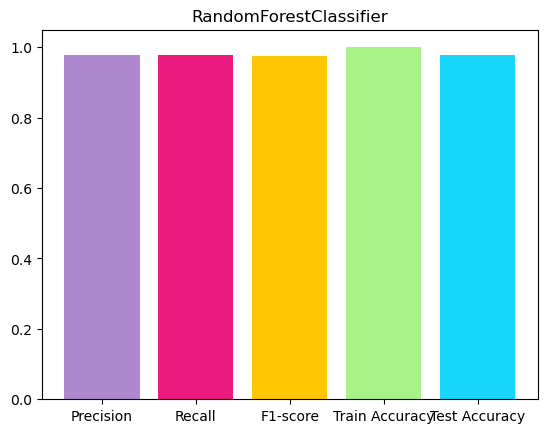

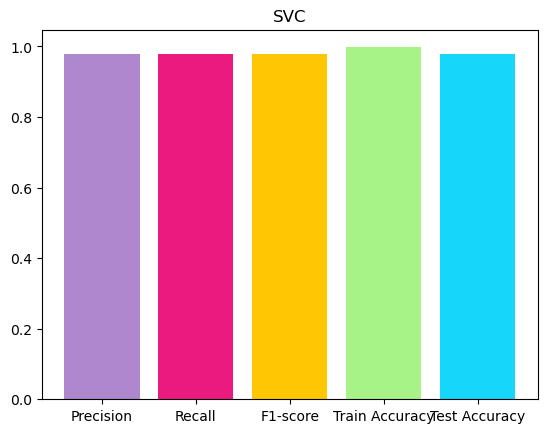

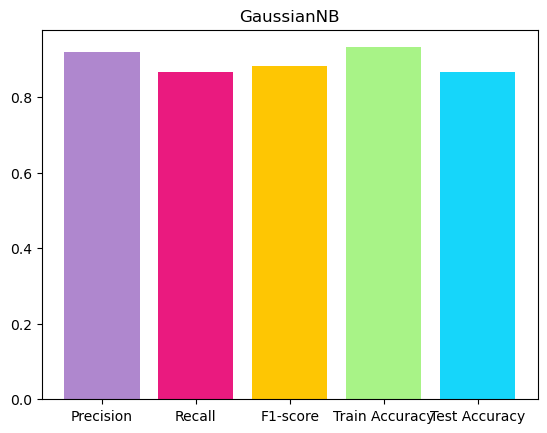

In [47]:
#color palette
color = ['#AF87CE','#EA1A7F','#FEC603','#A8F387','#16D6FA']

# Calculate classification report for each classifier
for clf in classifiers:
    # fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    #predict y based on x-test
    y_pred = clf.predict(X_test)
    
    #Make classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    trainset_accuracy = clf.score(X_train, y_train)
    testset_accuracy = clf.score(X_test, y_test)
    
    # Create bar chart for each classifier
    plt.bar([0, 1, 2, 3, 4], [precision, recall, f1_score, trainset_accuracy, testset_accuracy], color=color)
    plt.xticks([0, 1, 2, 3, 4], ['Precision', 'Recall', 'F1-score', 'Train Accuracy', 'Test Accuracy'])
    plt.title(type(clf).__name__)
    plt.show()